# Task 2: Actor-Critic for Minesweeper
## CS 462 - Fall 2025




## Setup


In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

import torch
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CUDA: True
GPU: Tesla T4


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.auto import tqdm
import copy

sns.set_style('whitegrid')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Minesweeper Game
same game from task 1

In [ ]:
class MinesweeperGame:
    def __init__(self, height=22, width=22, num_mines=80):
        self.height = height
        self.width = width
        self.num_mines = num_mines
        self.reset()

    def reset(self):
        # make board
        self.mine_map = np.zeros((self.height, self.width), dtype=bool)
        positions = [(i, j) for i in range(self.height) for j in range(self.width)]
        mine_positions = random.sample(positions, self.num_mines)
        for i, j in mine_positions:
            self.mine_map[i, j] = True

        # clue numbers
        self.clue_map = np.zeros((self.height, self.width), dtype=int)
        for i in range(self.height):
            for j in range(self.width):
                if not self.mine_map[i, j]:
                    self.clue_map[i, j] = self._count_adjacent_mines(i, j)

        self.revealed = np.zeros((self.height, self.width), dtype=bool)
        self.game_over = False
        self.mine_triggered = False
        self.num_revealed = 0
        self._reveal_first_cell()
        return self.get_state()

    def _count_adjacent_mines(self, i, j):
        count = 0
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    if self.mine_map[ni, nj]:
                        count += 1
        return count

    def _reveal_first_cell(self):
        # find a safe spot to start
        zero_cells = [(i, j) for i in range(self.height) for j in range(self.width)
                      if self.clue_map[i, j] == 0]
        if zero_cells:
            i, j = random.choice(zero_cells)
        else:
            non_mine_cells = [(i, j) for i in range(self.height) for j in range(self.width)
                             if not self.mine_map[i, j]]
            i, j = random.choice(non_mine_cells)
        self._reveal_cell_and_neighbors(i, j)

    def _reveal_cell_and_neighbors(self, i, j):
        if self.revealed[i, j]:
            return
        self.revealed[i, j] = True
        self.num_revealed += 1
        # if its a zero, reveal neighbors too
        if self.clue_map[i, j] == 0:
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = i + di, j + dj
                    if 0 <= ni < self.height and 0 <= nj < self.width:
                        if not self.revealed[ni, nj] and not self.mine_map[ni, nj]:
                            self._reveal_cell_and_neighbors(ni, nj)

    def step(self, i, j):
        if self.game_over:
            return self.get_state(), 0, True, {'mine_triggered': self.mine_triggered}
        if self.revealed[i, j]:
            return self.get_state(), 0, False, {}
        # boom
        if self.mine_map[i, j]:
            self.revealed[i, j] = True
            self.num_revealed += 1
            self.game_over = True
            self.mine_triggered = True
            return self.get_state(), -1, True, {'mine_triggered': True}
        # safe
        self._reveal_cell_and_neighbors(i, j)
        if self.num_revealed == self.height * self.width - self.num_mines:
            self.game_over = True
            return self.get_state(), 10, True, {'mine_triggered': False}
        return self.get_state(), 1, False, {'mine_triggered': False}

    def get_state(self):
        state = np.full((self.height, self.width), -1, dtype=int)
        state[self.revealed] = self.clue_map[self.revealed]
        return state

    def get_neighbors(self, i, j):
        neighbors = []
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni, nj = i + di, j + dj
                if 0 <= ni < self.height and 0 <= nj < self.width:
                    neighbors.append((ni, nj))
        return neighbors

print("game ready")

game ready


## Logic Bot
baseline bot from task 1. uses simple rules

In [ ]:
class LogicBot:
    def __init__(self, game):
        self.game = game
        self.height = game.height
        self.width = game.width
        self.inferred_safe = set()
        self.inferred_mine = set()
        self.cells_remaining = set((i, j) for i in range(self.height) for j in range(self.width))

    def play_game(self):
        state = self.game.reset()
        self._update_from_state(state)
        moves = 0

        while not self.game.game_over and moves < 200:
            self._make_inferences(state)
            if self.inferred_safe:
                i, j = self.inferred_safe.pop()
            else:
                if not self.cells_remaining:
                    break
                i, j = random.choice(list(self.cells_remaining))

            state, _, done, info = self.game.step(i, j)
            moves += 1
            self._update_from_state(state)

            if info.get('mine_triggered'):
                break

        return moves

    def _update_from_state(self, state):
        for i in range(self.height):
            for j in range(self.width):
                if state[i, j] >= 0:
                    self.cells_remaining.discard((i, j))
                    self.inferred_safe.discard((i, j))
                    self.inferred_mine.discard((i, j))

    def _make_inferences(self, state):
        # do logical reasoning
        made_inference = True
        while made_inference:
            made_inference = False
            for i in range(self.height):
                for j in range(self.width):
                    if state[i, j] < 0:
                        continue
                    clue = state[i, j]
                    neighbors = self.game.get_neighbors(i, j)
                    unrevealed_neighbors = []
                    inferred_mine_neighbors = 0
                    revealed_or_safe_neighbors = 0
                    for ni, nj in neighbors:
                        if (ni, nj) in self.inferred_mine:
                            inferred_mine_neighbors += 1
                        elif state[ni, nj] >= 0 or (ni, nj) in self.inferred_safe:
                            revealed_or_safe_neighbors += 1
                        else:
                            unrevealed_neighbors.append((ni, nj))
                    # rule 1: if clue matches unrevealed, all are mines
                    if clue - inferred_mine_neighbors == len(unrevealed_neighbors) and unrevealed_neighbors:
                        for ni, nj in unrevealed_neighbors:
                            if (ni, nj) not in self.inferred_mine:
                                self.inferred_mine.add((ni, nj))
                                self.cells_remaining.discard((ni, nj))
                                made_inference = True
                    # rule 2: if all mines accounted for, rest are safe
                    total_neighbors = len(neighbors)
                    if (total_neighbors - clue) - revealed_or_safe_neighbors == len(unrevealed_neighbors) and unrevealed_neighbors:
                        for ni, nj in unrevealed_neighbors:
                            if (ni, nj) not in self.inferred_safe:
                                self.inferred_safe.add((ni, nj))
                                self.cells_remaining.discard((ni, nj))
                                made_inference = True

print("logic bot ready")

logic bot ready


## Helper Functions


In [ ]:
def state_to_tensor(state):
    # 3 channels like in task 1
    revealed_mask = (state >= 0).astype(np.float32)
    clue_normalized = np.where(state >= 0, state / 8.0, 0).astype(np.float32)
    unrevealed_mask = (state < 0).astype(np.float32)
    tensor = np.stack([revealed_mask, clue_normalized, unrevealed_mask], axis=0)
    return torch.from_numpy(tensor)

def action_to_tensor(action, height=22, width=22):
    # action is (i, j), convert to one-hot map
    action_map = np.zeros((height, width), dtype=np.float32)
    action_map[action[0], action[1]] = 1.0
    return torch.from_numpy(action_map).unsqueeze(0)

print("helper functions ready")

helper functions ready


## Critic Network
takes (state, action) and predicts how many moves you'll survive



In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, in_channels=4):
        super(CriticNetwork, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        # dilated conv to see farther
        self.conv_d1 = nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2)
        self.bn_d1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # global pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # fc layers
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, state, action):
        # concat state and action
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_d1(self.conv_d1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

critic = CriticNetwork().to(device)
print(f"critic params: {sum(p.numel() for p in critic.parameters()):,}")

critic params: 300,481


## Actor Network
takes state and outputs which cell to click



In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, in_channels=3):
        super(ActorNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv_d1 = nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2)
        self.bn_d1 = nn.BatchNorm2d(128)
        self.conv_d2 = nn.Conv2d(128, 128, kernel_size=3, padding=4, dilation=4)
        self.bn_d2 = nn.BatchNorm2d(128)
        self.conv_out1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn_out1 = nn.BatchNorm2d(64)
        self.conv_out2 = nn.Conv2d(64, 1, kernel_size=1)
        self.dropout = nn.Dropout2d(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_d1(self.conv_d1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_d2(self.conv_d2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_out1(self.conv_out1(x)))
        x = self.conv_out2(x)
        return x.squeeze(1)

actor = ActorNetwork().to(device)
print(f"actor params: {sum(p.numel() for p in actor.parameters()):,}")

actor params: 445,697


## Collect Logic Bot Data

for each move we save:
- state (what board looks like)
- action (which cell logic bot picked)
- survival (how many moves after this did the game last)



In [ ]:
def collect_logic_bot_data(game, num_games=1500):
    data = []
    survival_counts = []

    for _ in tqdm(range(num_games), desc="watching logic bot play"):
        bot = LogicBot(game)
        state = game.reset()
        bot._update_from_state(state)

        game_states = []
        game_actions = []

        move_count = 0
        while not game.game_over and move_count < 200:
            game_states.append(state.copy())

            # logic bot picks action
            bot._make_inferences(state)
            if bot.inferred_safe:
                i, j = bot.inferred_safe.pop()
            else:
                unrevealed = [(i, j) for i in range(game.height) for j in range(game.width) if state[i, j] < 0]
                if not unrevealed:
                    break
                i, j = random.choice(unrevealed)

            game_actions.append((i, j))
            state, _, done, info = game.step(i, j)
            bot._update_from_state(state)
            move_count += 1

            if info.get('mine_triggered'):
                break

        # now assign survival values
        total_moves = len(game_actions)
        survival_counts.append(total_moves)

        for idx, (s, a) in enumerate(zip(game_states, game_actions)):
            survival_remaining = total_moves - idx
            data.append((s, a, survival_remaining))

    print(f"\ncollected {len(data)} samples from {num_games} games")
    print(f"average survival: {np.mean(survival_counts):.1f} moves")

    return data, survival_counts

print("data collection function ready")

data collection function ready


## Iteration 0: Logic Bot Baseline
first lets see how good logic bot is so we have something to compare to

In [ ]:
print("="*70)
print("ITERATION 0: LOGIC BOT BASELINE")
print("="*70)

game = MinesweeperGame(num_mines=80)

logic_bot_data, logic_bot_survivals = collect_logic_bot_data(game, num_games=1500)

print(f"\nlogic bot stats:")
print(f"  avg survival: {np.mean(logic_bot_survivals):.1f} moves")
print(f"  std: {np.std(logic_bot_survivals):.1f}")
print(f"  min: {np.min(logic_bot_survivals)}, max: {np.max(logic_bot_survivals)}")

ITERATION 0: LOGIC BOT BASELINE


watching logic bot play:   0%|          | 0/1500 [00:00<?, ?it/s]


collected 110247 samples from 1500 games
average survival: 73.5 moves

logic bot stats:
  avg survival: 73.5 moves
  std: 68.6
  min: 1, max: 200


## Train Critic
teach critic to predict survival from logic bot games

critic learns: given (state, action) → how many moves will survive

using MSE loss; regression not classification

training critic...


epoch 1/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 1/10 - loss: 1773.1436


epoch 2/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 2/10 - loss: 928.6718


epoch 3/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 3/10 - loss: 858.4137


epoch 4/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 4/10 - loss: 783.2013


epoch 5/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 5/10 - loss: 736.3575


epoch 6/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 6/10 - loss: 685.4563


epoch 7/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 7/10 - loss: 646.2219


epoch 8/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 8/10 - loss: 610.3063


epoch 9/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 9/10 - loss: 580.6241


epoch 10/10:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 10/10 - loss: 552.2498


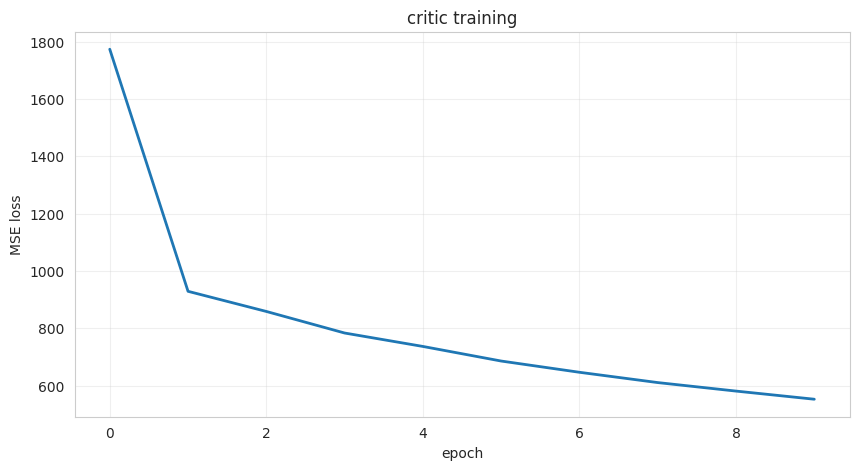

In [ ]:
class SurvivalDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, survival = self.data[idx]
        state_tensor = state_to_tensor(state)
        action_tensor = action_to_tensor(action)
        survival_tensor = torch.tensor(survival, dtype=torch.float32)
        return state_tensor, action_tensor, survival_tensor

def train_critic(critic, data, num_epochs=10, batch_size=64, lr=0.0005):
    dataset = SurvivalDataset(data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(critic.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(num_epochs):
        critic.train()
        epoch_loss = 0

        for states, actions, survivals in tqdm(loader, desc=f"epoch {epoch+1}/{num_epochs}", leave=False):
            states = states.to(device)
            actions = actions.to(device)
            survivals = survivals.to(device)

            optimizer.zero_grad()
            predictions = critic(states, actions)
            loss = criterion(predictions, survivals)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        print(f"epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}")

    return losses

print("training critic...")
critic_losses = train_critic(critic, logic_bot_data, num_epochs=10)

plt.figure(figsize=(10, 5))
plt.plot(critic_losses, linewidth=2)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.title('critic training')
plt.grid(True, alpha=0.3)
plt.show()

## Train Actor (Supervised Learning)

we use cross entropy loss because we're predicting which cell to pick (classification)

In [ ]:
def train_actor_supervised(actor, data, num_epochs=15, batch_size=64, lr=0.001):
    dataset = SurvivalDataset(data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(actor.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    losses = []
    accuracies = []

    for epoch in range(num_epochs):
        actor.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for states, actions, _ in tqdm(loader, desc=f"epoch {epoch+1}/{num_epochs}", leave=False):
            states = states.to(device)
            actions = actions.to(device)

            optimizer.zero_grad()

            # actor outputs score for each cell
            action_scores = actor(states)

            # mask revealed cells
            unrevealed_mask = (states[:, 2, :, :] > 0).float()
            masked_scores = action_scores.clone()
            masked_scores[unrevealed_mask == 0] = -1e9

            # flatten
            flat_scores = masked_scores.view(masked_scores.size(0), -1)

            # get target action index
            actions_squeezed = actions.squeeze(1)
            action_indices = torch.argmax(actions_squeezed.view(actions_squeezed.size(0), -1), dim=1)

            # supervised learning loss
            loss = criterion(flat_scores, action_indices)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # accuracy
            predictions = torch.argmax(flat_scores, dim=1)
            correct += (predictions == action_indices).sum().item()
            total += action_indices.size(0)

        avg_loss = epoch_loss / len(loader)
        accuracy = correct / total
        losses.append(avg_loss)
        accuracies.append(accuracy)

        print(f"epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}, accuracy: {accuracy:.3f}")

    return losses, accuracies

print("supervised training function ready")

supervised training function ready


## Iteration 1: Train Actor
teaching actor to copy logic bot

ITERATION 1: SUPERVISED PRETRAINING

training actor to imitate logic bot...


epoch 1/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 1/15 - loss: 3.0506, accuracy: 0.203


epoch 2/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 2/15 - loss: 2.6514, accuracy: 0.268


epoch 3/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 3/15 - loss: 2.5213, accuracy: 0.293


epoch 4/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 4/15 - loss: 2.4407, accuracy: 0.308


epoch 5/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 5/15 - loss: 2.3831, accuracy: 0.321


epoch 6/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 6/15 - loss: 2.3386, accuracy: 0.327


epoch 7/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 7/15 - loss: 2.3001, accuracy: 0.338


epoch 8/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 8/15 - loss: 2.2704, accuracy: 0.345


epoch 9/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 9/15 - loss: 2.2459, accuracy: 0.347


epoch 10/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 10/15 - loss: 2.2246, accuracy: 0.353


epoch 11/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 11/15 - loss: 2.2057, accuracy: 0.357


epoch 12/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 12/15 - loss: 2.1860, accuracy: 0.361


epoch 13/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 13/15 - loss: 2.1733, accuracy: 0.363


epoch 14/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 14/15 - loss: 2.1574, accuracy: 0.369


epoch 15/15:   0%|          | 0/1723 [00:00<?, ?it/s]

epoch 15/15 - loss: 2.1454, accuracy: 0.370


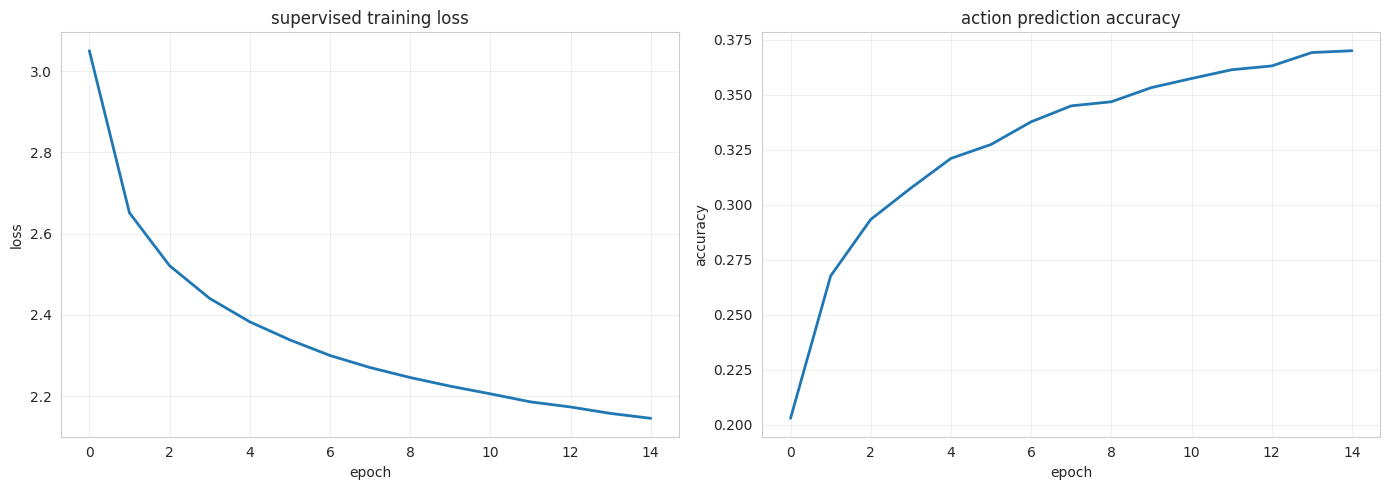

In [ ]:
print("="*70)
print("ITERATION 1: SUPERVISED PRETRAINING")
print("="*70)

print("\ntraining actor to imitate logic bot...")
supervised_losses, supervised_accuracies = train_actor_supervised(
    actor,
    logic_bot_data,
    num_epochs=15,
    batch_size=64,
    lr=0.001
)

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(supervised_losses, linewidth=2)
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].set_title('supervised training loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(supervised_accuracies, linewidth=2)
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].set_title('action prediction accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Actor Playing Function
function to let actor play a game

In [ ]:
def play_game_with_actor(actor, game, epsilon=0.0):
    actor.eval()
    state = game.reset()
    moves = 0

    while not game.game_over and moves < 200:
        state_tensor = state_to_tensor(state).unsqueeze(0).to(device)

        with torch.no_grad():
            action_scores = actor(state_tensor).cpu().numpy()[0]

        # mask revealed
        unrevealed_mask = (state < 0)
        if not unrevealed_mask.any():
            break

        if random.random() < epsilon:
            # random
            unrevealed_positions = np.argwhere(unrevealed_mask)
            idx = random.choice(range(len(unrevealed_positions)))
            i, j = unrevealed_positions[idx]
        else:
            # pick best
            masked_scores = np.where(unrevealed_mask, action_scores, -1e9)
            i, j = np.unravel_index(masked_scores.argmax(), masked_scores.shape)

        state, _, done, info = game.step(i, j)
        moves += 1

        if info.get('mine_triggered'):
            break

    return moves

def evaluate_actor(actor, game, num_games=100):
    survivals = []
    for _ in tqdm(range(num_games), desc="evaluating actor"):
        moves = play_game_with_actor(actor, game, epsilon=0.0)
        survivals.append(moves)
    return survivals

print("actor playing functions ready")

actor playing functions ready


## Evaluate Iteration 1
lets see how good actor is after learning from logic bot


evaluating iteration 1...


evaluating actor:   0%|          | 0/200 [00:00<?, ?it/s]


iteration 1 stats:
  avg survival: 54.7 moves
  std: 57.7
  min: 1, max: 191

comparison:
  logic bot: 73.5 moves
  iteration 1: 54.7 moves


/tmp/ipython-input-3920859097.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([logic_bot_survivals, iter1_survivals], labels=['logic bot', 'iteration 1'])


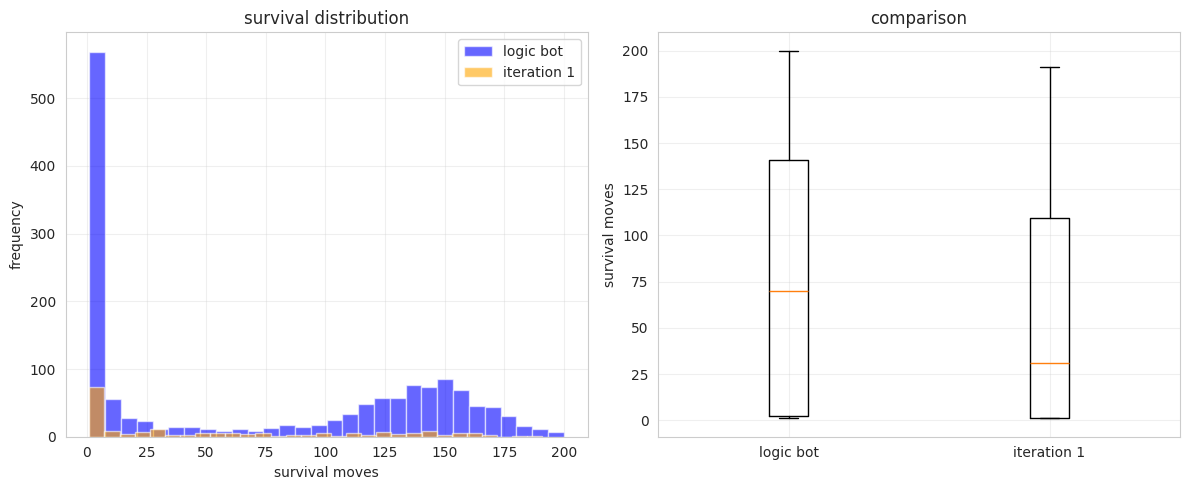

In [ ]:
print("\nevaluating iteration 1...")
iter1_survivals = evaluate_actor(actor, game, num_games=200)

print(f"\niteration 1 stats:")
print(f"  avg survival: {np.mean(iter1_survivals):.1f} moves")
print(f"  std: {np.std(iter1_survivals):.1f}")
print(f"  min: {np.min(iter1_survivals)}, max: {np.max(iter1_survivals)}")

print(f"\ncomparison:")
print(f"  logic bot: {np.mean(logic_bot_survivals):.1f} moves")
print(f"  iteration 1: {np.mean(iter1_survivals):.1f} moves")

# plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(logic_bot_survivals, bins=30, alpha=0.6, label='logic bot', color='blue')
plt.hist(iter1_survivals, bins=30, alpha=0.6, label='iteration 1', color='orange')
plt.xlabel('survival moves')
plt.ylabel('frequency')
plt.title('survival distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([logic_bot_survivals, iter1_survivals], labels=['logic bot', 'iteration 1'])
plt.ylabel('survival moves')
plt.title('comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Iteration 2: Bootstrap Improvement
now we try to improve actor by using critic

process:
1. collect data from actor playing
2. retrain critic on this data
3. use critic to help actor get better

this is the "bootstrapping" part - actor learns from its own games

In [ ]:
def collect_actor_data(actor, game, num_games=1000):
    # same as logic bot data collection but using actor
    data = []
    survival_counts = []

    for _ in tqdm(range(num_games), desc="collecting actor data"):
        actor.eval()
        state = game.reset()

        game_states = []
        game_actions = []

        moves = 0
        while not game.game_over and moves < 200:
            game_states.append(state.copy())

            state_tensor = state_to_tensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_scores = actor(state_tensor).cpu().numpy()[0]

            unrevealed_mask = (state < 0)
            if not unrevealed_mask.any():
                break

            masked_scores = np.where(unrevealed_mask, action_scores, -1e9)
            i, j = np.unravel_index(masked_scores.argmax(), masked_scores.shape)

            game_actions.append((i, j))
            state, _, done, info = game.step(i, j)
            moves += 1

            if info.get('mine_triggered'):
                break

        total_moves = len(game_actions)
        survival_counts.append(total_moves)

        for idx, (s, a) in enumerate(zip(game_states, game_actions)):
            survival_remaining = total_moves - idx
            data.append((s, a, survival_remaining))

    print(f"\ncollected {len(data)} samples, avg survival: {np.mean(survival_counts):.1f}")
    return data, survival_counts

print("="*70)
print("ITERATION 2: BOOTSTRAPPING (WITH LOGIC BOT DATA)")
print("="*70)

# collect data from actor
print("\nactor playing games...")
iter2_data_actor, iter2_survivals_collection = collect_actor_data(actor, game, num_games=1000)  # Reduce to 1000

# MIX with logic bot data
print(f"\nmixing actor data ({len(iter2_data_actor)} samples) with logic bot data ({len(logic_bot_data)} samples)")
iter2_data = logic_bot_data + iter2_data_actor  # Combine both
import random
random.shuffle(iter2_data)
print(f"total training data: {len(iter2_data)} samples")

# retrain critic on mixed data
print("\nretraining critic on mixed data...")
critic_losses_iter2 = train_critic(critic, iter2_data, num_epochs=10)

# fine-tune actor on mixed data
print("\nfine-tuning actor on mixed data...")
actor_losses_iter2, actor_acc_iter2 = train_actor_supervised(
    actor,
    iter2_data,  # Mixed data
    num_epochs=5,
    batch_size=64,
    lr=0.0001
)

# evaluate
print("\nevaluating iteration 2...")
iter2_survivals = evaluate_actor(actor, game, num_games=200)

print(f"\niteration 2 stats:")
print(f"  avg survival: {np.mean(iter2_survivals):.1f} moves")
print(f"  std: {np.std(iter2_survivals):.1f}")

print(f"\nprogression:")
print(f"  logic bot (iter 0): {np.mean(logic_bot_survivals):.1f} moves")
print(f"  iteration 1: {np.mean(iter1_survivals):.1f} moves")
print(f"  iteration 2: {np.mean(iter2_survivals):.1f} moves")



ITERATION 2: BOOTSTRAPPING (WITH LOGIC BOT DATA)

actor playing games...


collecting actor data:   0%|          | 0/1000 [00:00<?, ?it/s]


collected 60386 samples, avg survival: 60.4

mixing actor data (60386 samples) with logic bot data (110247 samples)
total training data: 170633 samples

retraining critic on mixed data...


epoch 1/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 1/10 - loss: 612.5693


epoch 2/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 2/10 - loss: 482.2430


epoch 3/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 3/10 - loss: 435.0621


epoch 4/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 4/10 - loss: 406.1334


epoch 5/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 5/10 - loss: 383.4100


epoch 6/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 6/10 - loss: 367.3888


epoch 7/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 7/10 - loss: 349.7367


epoch 8/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 8/10 - loss: 342.6912


epoch 9/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 9/10 - loss: 330.7493


epoch 10/10:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 10/10 - loss: 326.0321

fine-tuning actor on mixed data...


epoch 1/5:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 1/5 - loss: 1.6750, accuracy: 0.506


epoch 2/5:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 2/5 - loss: 1.6626, accuracy: 0.510


epoch 3/5:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 3/5 - loss: 1.6567, accuracy: 0.510


epoch 4/5:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 4/5 - loss: 1.6449, accuracy: 0.516


epoch 5/5:   0%|          | 0/2667 [00:00<?, ?it/s]

epoch 5/5 - loss: 1.6387, accuracy: 0.516

evaluating iteration 2...


evaluating actor:   0%|          | 0/200 [00:00<?, ?it/s]


iteration 2 stats:
  avg survival: 58.1 moves
  std: 62.0

progression:
  logic bot (iter 0): 73.5 moves
  iteration 1: 54.7 moves
  iteration 2: 58.1 moves


## Final Analysis


FINAL RESULTS

iter 0 (logic bot):
  mean: 73.50 ± 68.61
  median: 70.0
  min: 1, max: 200

iter 1:
  mean: 54.70 ± 57.68
  median: 31.0
  min: 1, max: 191

iter 2:
  mean: 58.83 ± 63.07
  median: 26.5
  min: 1, max: 200


/tmp/ipython-input-2233899613.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([logic_bot_survivals, iter1_survivals, iter2_survivals],


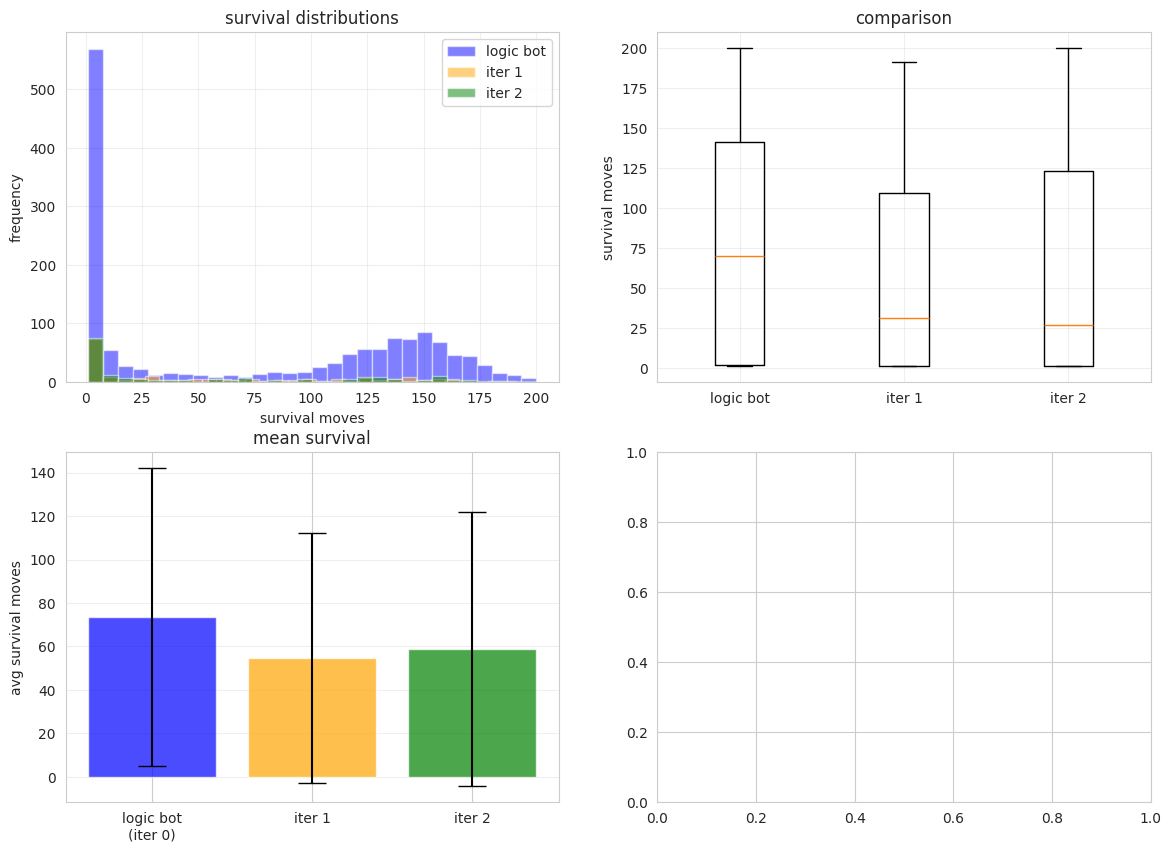

In [ ]:
results = {
    'iter 0 (logic bot)': logic_bot_survivals,
    'iter 1': iter1_survivals,
    'iter 2': iter2_survivals
}

print("="*70)
print("FINAL RESULTS")
print("="*70)

for name, survivals in results.items():
    print(f"\n{name}:")
    print(f"  mean: {np.mean(survivals):.2f} ± {np.std(survivals):.2f}")
    print(f"  median: {np.median(survivals):.1f}")
    print(f"  min: {np.min(survivals)}, max: {np.max(survivals)}")

# big plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# distributions
axes[0, 0].hist(logic_bot_survivals, bins=30, alpha=0.5, label='logic bot', color='blue')
axes[0, 0].hist(iter1_survivals, bins=30, alpha=0.5, label='iter 1', color='orange')
axes[0, 0].hist(iter2_survivals, bins=30, alpha=0.5, label='iter 2', color='green')
axes[0, 0].set_xlabel('survival moves')
axes[0, 0].set_ylabel('frequency')
axes[0, 0].set_title('survival distributions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# box plot
axes[0, 1].boxplot([logic_bot_survivals, iter1_survivals, iter2_survivals],
                    labels=['logic bot', 'iter 1', 'iter 2'])
axes[0, 1].set_ylabel('survival moves')
axes[0, 1].set_title('comparison')
axes[0, 1].grid(True, alpha=0.3)

# mean progression
means = [np.mean(logic_bot_survivals), np.mean(iter1_survivals), np.mean(iter2_survivals)]
stds = [np.std(logic_bot_survivals), np.std(iter1_survivals), np.std(iter2_survivals)]
iterations = ['logic bot\n(iter 0)', 'iter 1', 'iter 2']
axes[1, 0].bar(iterations, means, yerr=stds, capsize=10, alpha=0.7, color=['blue', 'orange', 'green'])
axes[1, 0].set_ylabel('avg survival moves')
axes[1, 0].set_title('mean survival')
axes[1, 0].grid(True, alpha=0.3, axis='y')




## Save Everything
save models and results

In [ ]:
torch.save({
    'actor_state_dict': actor.state_dict(),
    'critic_state_dict': critic.state_dict(),
    'results': results,
    'means': means,
    'stds': stds
}, 'task2_models.pth')

print("saved to task2_models.pth")

if IN_COLAB:
    !cp task2_models.pth /content/drive/MyDrive/
    print("also saved to google drive")

saved to task2_models.pth
also saved to google drive
